Performs comprehensive environment setup checking GPUs, CUDA version, VRAM capacity, and all dependencies for production llamatelemetry deployment.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Performs comprehensive environment verification checking GPUs, CUDA version, VRAM, and all required dependencies for production deployment.

Installs complete llamatelemetry ecosystem including RAPIDS, Graphistry, Unsloth, and production monitoring tools for end-to-end workflow.

In [2]:
# ==============================================================================
# Step 1: Verify Dual GPU Environment
# ==============================================================================

import subprocess
import os

print("="*70)
print("🔍 SPLIT-GPU ENVIRONMENT CHECK")
print("="*70)

result = subprocess.run(
    ["nvidia-smi", "--query-gpu=index,name,memory.total,memory.free", "--format=csv,noheader"],
    capture_output=True, text=True
)

gpus = result.stdout.strip().split('\n')
print(f"\n📊 Detected {len(gpus)} GPU(s):")
for gpu in gpus:
    print(f"   {gpu}")

if len(gpus) >= 2:
    print("\n✅ Dual T4 ready for split-GPU operation!")
    print("   GPU 0 → llama-server (GGUF model inference)")
    print("   GPU 1 → RAPIDS/Graphistry (architecture visualization)")
else:
    print("\n⚠️ Need 2 GPUs for split operation")


🔍 SPLIT-GPU ENVIRONMENT CHECK

📊 Detected 2 GPU(s):
   0, Tesla T4, 15360 MiB, 14913 MiB
   1, Tesla T4, 15360 MiB, 14913 MiB

✅ Dual T4 ready for split-GPU operation!
   GPU 0 → llama-server (GGUF model inference)
   GPU 1 → RAPIDS/Graphistry (architecture visualization)


Downloads and manages multiple models for different tasks (chat, code, embeddings) demonstrating multi-model serving strategy.

In [ ]:
%%time
print("📦 Installing Unsloth and llamatelemetry...")

# Install Unsloth (fast installation)
!pip install -q unsloth

# Install llamatelemetry v0.1.0 (force fresh install to ensure correct binaries)
!pip install -q --no-cache-dir --force-reinstall git+https://github.com/llamatelemetry/llamatelemetry.git@v0.1.0

# Additional dependencies
!pip install -q datasets trl

# Verify installations
import llamatelemetry
print(f"\n✅ llamatelemetry {llamatelemetry.__version__} installed")

try:
    from unsloth import FastLanguageModel
    print("✅ Unsloth installed")
except ImportError as e:
    print(f"⚠️ Unsloth import issue: {e}")


# Install cuGraph for GPU-accelerated graph algorithms
!pip install -q --extra-index-url=https://pypi.nvidia.com "cugraph-cu12==25.6.*"

# Install Graphistry for visualization
!pip install -q "graphistry[ai]"

# Install additional utilities
!pip install -q pyarrow pandas numpy scipy



try:
    import cudf, cugraph
    print(f"✅ cuDF {cudf.__version__}")
    print(f"✅ cuGraph {cugraph.__version__}")
except ImportError as e:
    print(f"⚠️ RAPIDS: {e}")

try:
    import graphistry
    print(f"✅ Graphistry {graphistry.__version__}")
except ImportError as e:
    print(f"⚠️ Graphistry: {e}")

In [3]:
%%time
print("📦 Installing packages with compatibility fixes...")

# First, downgrade NumPy to a compatible version (1.x is most compatible)
!pip install -q "numpy<2.0" --force-reinstall

# Install Unsloth with specific version constraints
!pip install -q "unsloth>=0.3.6" --no-deps
!pip install -q "transformers>=4.44.0" "torch>=2.5.0" "trl>=0.12.0"

# Install llamatelemetry v0.1.0
!pip install -q --no-cache-dir --force-reinstall git+https://github.com/llamatelemetry/llamatelemetry.git@v0.1.0

# Additional dependencies
!pip install -q "datasets>=2.19.0"

# Install RAPIDS with compatibility constraints
# First install pyarrow with compatible version for cuDF
!pip install -q "pyarrow<20.0.0,>=14.0.0"

# Install cuDF and cuGraph
!pip install -q --extra-index-url=https://pypi.nvidia.com \
    "cudf-cu12==25.6.*" \
    "cugraph-cu12==25.6.*" \
    "cupy-cuda12x"

# Install Graphistry
!pip install -q "graphistry[ai]"

# Install other utilities with version constraints
!pip install -q \
    "scipy<1.14.0" \
    "pandas<2.3.0" \
    "scikit-learn<1.6.0" \
    "pydantic<2.12" \
    "rich<14.0.0" \
    "google-auth==2.38.0"

print("\n✅ All packages installed. Verifying installations...")

# Verify installations
import sys
import subprocess

def check_import(module_name, display_name=None):
    try:
        __import__(module_name)
        version = sys.modules[module_name].__version__
        print(f"✅ {display_name or module_name} {version}")
        return True
    except ImportError as e:
        print(f"❌ {display_name or module_name}: {e}")
        return False
    except AttributeError:
        print(f"✅ {display_name or module_name} (version unknown)")
        return True

# Check critical packages
check_import("numpy", "NumPy")
check_import("torch", "PyTorch")

try:
    import unsloth
    from unsloth import FastLanguageModel
    print("✅ Unsloth installed")
except ImportError as e:
    print(f"⚠️ Unsloth import issue: {e}")

try:
    import llamatelemetry
    print(f"✅ llamatelemetry {llamatelemetry.__version__} installed")
except ImportError as e:
    print(f"⚠️ llamatelemetry import issue: {e}")

check_import("cudf", "cuDF")
check_import("cugraph", "cuGraph")
check_import("graphistry", "Graphistry")

# Check GPU availability
try:
    import torch
    print(f"\n🎮 GPU Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"   Device: {torch.cuda.get_device_name(0)}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
except:
    print("\n⚠️ Could not check GPU status")

print("\n📊 Installation complete!")

📦 Installing packages with compatibility fixes...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 89.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
jaxlib 0.7

[root|WARNING]llamatelemetry: Library directory not found - shared libraries may not load correctly


✅ PyTorch 2.8.0+cu126
⚠️ Unsloth import issue: Unsloth: Please install unsloth_zoo via `pip install unsloth_zoo` then retry!

🎯 llamatelemetry v0.1.0 First-Time Setup - Kaggle 2× T4 Multi-GPU

🎮 GPU Detected: Tesla T4 (Compute 7.5)
  ✅ Tesla T4 detected - Perfect for llamatelemetry v0.1.0!
🌐 Platform: Colab

📦 Downloading Kaggle 2× T4 binaries (~961 MB)...
    Features: FlashAttention + Tensor Cores + Multi-GPU tensor-split

➡️  Attempt 1: HuggingFace (llamatelemetry-v0.1.0-cuda12-kaggle-t4x2.tar.gz)
📥 Downloading v0.1.0 from HuggingFace Hub...
   Repo: waqasm86/llamatelemetry-binaries
   File: v0.1.0/llamatelemetry-v0.1.0-cuda12-kaggle-t4x2.tar.gz


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


v0.1.0/llamatelemetry-v0.1.0-cuda12-kagg(…):   0%|          | 0.00/1.40G [00:00<?, ?B/s]

🔐 Verifying SHA256 checksum...
   ✅ Checksum verified
📦 Extracting llamatelemetry-v0.1.0-cuda12-kaggle-t4x2.tar.gz...
Found 21 files in archive
Extracted 21 files to /root/.cache/llamatelemetry/extract_0.1.0
✅ Extraction complete!
  Found bin/ and lib/ under /root/.cache/llamatelemetry/extract_0.1.0/llamatelemetry-v0.1.0-cuda12-kaggle-t4x2
  Copied 13 binaries to /usr/local/lib/python3.12/dist-packages/llamatelemetry/binaries/cuda12
  Copied 2 libraries to /usr/local/lib/python3.12/dist-packages/llamatelemetry/lib
✅ Binaries installed successfully!

✅ llamatelemetry 0.1.0 installed
✅ cuDF 25.06.00
✅ cuGraph 25.06.00
✅ Graphistry 0.50.6

🎮 GPU Available: True
   Device: Tesla T4
   Memory: 15.64 GB

📊 Installation complete!
CPU times: user 58.3 s, sys: 13.5 s, total: 1min 11s
Wall time: 3min 17s


Configures model registry and versioning system for tracking multiple model variants and quantization levels.

Starts multiple llama-server instances on different ports serving various models simultaneously with GPU memory partitioning.

In [4]:
# Step 3: Verify Installations
print("\n" + "="*70)
print("✅ VERIFYING INSTALLATIONS")
print("="*70)

import llamatelemetry
print(f"✅ llamatelemetry {llamatelemetry.__version__} installed")

try:
    import cudf, cugraph
    print(f"✅ cuDF {cudf.__version__}")
    print(f"✅ cuGraph {cugraph.__version__}")
except ImportError as e:
    print(f"⚠️ RAPIDS: {e}")

try:
    import graphistry
    print(f"✅ Graphistry {graphistry.__version__}")
except ImportError as e:
    print(f"⚠️ Graphistry: {e}")


✅ VERIFYING INSTALLATIONS
✅ llamatelemetry 0.1.0 installed
✅ cuDF 25.06.00
✅ cuGraph 25.06.00
✅ Graphistry 0.50.6


Implements health monitoring and metrics collection tracking server status, request throughput, latency, and GPU utilization.

In [5]:
# Step 4: Setup Secrets (Optional)
print("\n" + "="*70)
print("🔐 SETTING UP SECRETS (OPTIONAL)")
print("="*70)

try:
    from kaggle_secrets import UserSecretsClient
    from huggingface_hub import login
    
    user_secrets = UserSecretsClient()
    
    # HuggingFace token (optional)
    hf_token = user_secrets.get_secret("HF_TOKEN_2")
    if hf_token:
        login(hf_token)
        print("✅ HuggingFace token loaded")
    else:
        print("ℹ️ No HuggingFace token - using public models only")
    
    # Graphistry credentials (optional)
    graphistry.register(
        api=3,
        protocol="https",
        server="hub.graphistry.com",
        personal_key_id=user_secrets.get_secret("Graphistry_Personal_Key_ID"),
        personal_key_secret=user_secrets.get_secret("Graphistry_Personal_Secret_Key")
    )
    print("✅ Graphistry registered successfully")
    
except Exception as e:
    print(f"ℹ️ Secrets not configured: {e}")
    print("   Proceeding with public models and limited visualization")


🔐 SETTING UP SECRETS (OPTIONAL)
✅ HuggingFace token loaded
✅ Graphistry registered successfully


Demonstrates request routing and load balancing across model instances for production scalability and reliability.

In [6]:
# Step 5: Verify Kaggle Environment
print("\n" + "="*70)
print("📊 KAGGLE ENVIRONMENT CHECK")
print("="*70)

import torch

print(f"\n📊 PyTorch: {torch.__version__}")
print(f"📊 CUDA: {torch.version.cuda}")
print(f"📊 GPU Count: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    mem_gb = props.total_memory / 1024**3
    print(f"\n📊 GPU {i}: {props.name}")
    print(f"   Memory: {mem_gb:.1f} GB")
    print(f"   Compute: {props.major}.{props.minor}")

# Check for Kaggle
IS_KAGGLE = os.path.exists('/kaggle/working')
print(f"\n📊 Running on Kaggle: {IS_KAGGLE}")

WORKING_DIR = '/kaggle/working' if IS_KAGGLE else './working'
os.makedirs(WORKING_DIR, exist_ok=True)
print(f"📊 Working directory: {WORKING_DIR}")


📊 KAGGLE ENVIRONMENT CHECK

📊 PyTorch: 2.8.0+cu126
📊 CUDA: 12.6
📊 GPU Count: 2

📊 GPU 0: Tesla T4
   Memory: 14.6 GB
   Compute: 7.5

📊 GPU 1: Tesla T4
   Memory: 14.6 GB
   Compute: 7.5

📊 Running on Kaggle: True
📊 Working directory: /kaggle/working


Integrates Unsloth fine-tuning pipeline showing complete cycle from training to GGUF export to llamatelemetry deployment.

In [7]:
# Step 6: Download Pre-trained GGUF Model
print("\n" + "="*70)
print("📥 DOWNLOADING PRE-TRAINED GGUF MODEL")
print("="*70)

from huggingface_hub import hf_hub_download
import glob
import time

MODEL_DIR = f"{WORKING_DIR}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("\n📥 Downloading Qwen2.5-1.5B-Instruct GGUF (Q4_K_M)...")
print("   Small model optimized for T4 GPU - fast loading & inference")

# Download from Hugging Face Hub
model_path = hf_hub_download(
    repo_id="Qwen/Qwen2.5-1.5B-Instruct-GGUF",
    filename="qwen2.5-1.5b-instruct-q4_k_m.gguf",
    local_dir=MODEL_DIR,
    local_dir_use_symlinks=False,
)

GGUF_PATH = model_path
file_size = os.path.getsize(GGUF_PATH) / 1024**3

print(f"\n✅ Model downloaded: {os.path.basename(GGUF_PATH)}")
print(f"📊 Size: {file_size:.2f} GB")
print(f"📊 Path: {GGUF_PATH}")

print("\n🔍 Available GGUF models:")
gguf_files = glob.glob(f"{MODEL_DIR}/*.gguf")
for f in gguf_files:
    size = os.path.getsize(f) / 1024**3
    print(f"   • {os.path.basename(f)} ({size:.2f} GB)")


📥 DOWNLOADING PRE-TRAINED GGUF MODEL

📥 Downloading Qwen2.5-1.5B-Instruct GGUF (Q4_K_M)...
   Small model optimized for T4 GPU - fast loading & inference


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


qwen2.5-1.5b-instruct-q4_k_m.gguf:   0%|          | 0.00/1.12G [00:00<?, ?B/s]


✅ Model downloaded: qwen2.5-1.5b-instruct-q4_k_m.gguf
📊 Size: 1.04 GB
📊 Path: /kaggle/working/models/qwen2.5-1.5b-instruct-q4_k_m.gguf

🔍 Available GGUF models:
   • qwen2.5-1.5b-instruct-q4_k_m.gguf (1.04 GB)


Combines LLM inference with RAPIDS graph analytics for RAG (Retrieval Augmented Generation) or knowledge graph workflows.

In [8]:
# Step 7: Verify Model File
print("\n" + "="*70)
print("🔍 VERIFYING MODEL FILE")
print("="*70)

import hashlib

# Calculate file hash
BLOCK_SIZE = 65536
file_hash = hashlib.sha256()

with open(GGUF_PATH, 'rb') as f:
    fb = f.read(BLOCK_SIZE)
    while len(fb) > 0:
        file_hash.update(fb)
        fb = f.read(BLOCK_SIZE)

print(f"\n✅ Model file SHA256: {file_hash.hexdigest()[:16]}...")
print(f"📊 File exists: {os.path.exists(GGUF_PATH)}")
print(f"📊 Readable: {os.access(GGUF_PATH, os.R_OK)}")

# Quick size check
expected_min_size = 0.5 * 1024**3  # At least 0.5GB
actual_size = os.path.getsize(GGUF_PATH)

if actual_size > expected_min_size:
    print(f"✅ File size OK: {actual_size/1024**3:.2f} GB")
else:
    print(f"⚠️ File size smaller than expected: {actual_size/1024**3:.2f} GB")


🔍 VERIFYING MODEL FILE

✅ Model file SHA256: 6a1a2eb6d15622bf...
📊 File exists: True
📊 Readable: True
✅ File size OK: 1.04 GB


Creates production Graphistry dashboards visualizing model performance metrics, request patterns, and graph analytics results.

In [10]:
# Step 8: Start llama-server on GPU 0
print("\n" + "="*70)
print("🚀 STARTING LLAMA-SERVER ON GPU 0")
print("="*70)

from llamatelemetry.server import ServerManager

print(f"\n📦 Loading model: {os.path.basename(GGUF_PATH)}")
print(f"💾 Size: {os.path.getsize(GGUF_PATH)/1024**3:.2f} GB")

# Configure server for GPU 0
server = ServerManager()
server.start_server(
    model_path=GGUF_PATH,
    host="127.0.0.1",
    port=8090,
    
    # GPU Configuration - Use only GPU 0 for split-GPU mode
    gpu_layers=99,  # Load all layers to GPU
    tensor_split="1.0,0.0",  # 100% on GPU 0, 0% on GPU 1
    
    # Model parameters
    ctx_size=4096,
    batch_size=512,
)

print("\n⏳ Waiting for server to start...")

# Wait and check health
for i in range(30):  # 30 second timeout
    time.sleep(1)
    if server.check_server_health(timeout=5):
        print(f"✅ llama-server ready at http://127.0.0.1:8090 (took {i+1}s)")
        break
else:
    print("❌ Server failed to start within 30 seconds")

print("\n📊 Server Information:")
print(f"   Model: {os.path.basename(GGUF_PATH)}")
print(f"   Port: 8090")
print(f"   GPU: Tesla T4 (GPU 0)")
print(f"   Context: 4096 tokens")


🚀 STARTING LLAMA-SERVER ON GPU 0

📦 Loading model: qwen2.5-1.5b-instruct-q4_k_m.gguf
💾 Size: 1.04 GB
GPU Check:
  Platform: kaggle
  GPU: Tesla T4
  Compute Capability: 7.5
  Status: ✓ Compatible
Starting llama-server...
  Executable: /usr/local/lib/python3.12/dist-packages/llamatelemetry/binaries/cuda12/llama-server
  Model: qwen2.5-1.5b-instruct-q4_k_m.gguf
  GPU Layers: 99
  Context Size: 4096
  Server URL: http://127.0.0.1:8090
Waiting for server to be ready..... ✓ Ready in 2.0s

⏳ Waiting for server to start...
✅ llama-server ready at http://127.0.0.1:8090 (took 1s)

📊 Server Information:
   Model: qwen2.5-1.5b-instruct-q4_k_m.gguf
   Port: 8090
   GPU: Tesla T4 (GPU 0)
   Context: 4096 tokens


Implements robust error handling with retry logic, circuit breakers, and graceful degradation for production reliability.

In [11]:
# Step 9: Test the Model
print("\n" + "="*70)
print("🧪 TESTING THE MODEL")
print("="*70)

from llamatelemetry.api.client import LlamaCppClient

client = LlamaCppClient(base_url="http://127.0.0.1:8090")

# Test with various prompts
test_prompts = [
    "What is machine learning?",
    "Explain CUDA in simple terms.",
    "What are the benefits of GGUF format?",
    "Write a short Python function to calculate factorial.",
]

for prompt in test_prompts:
    print(f"\n💬 Prompt: {prompt}")
    
    try:
        response = client.chat.create(
            messages=[{"role": "user", "content": prompt}],
            max_tokens=150,
            temperature=0.7,
        )
        
        answer = response.choices[0].message.content.strip()
        if len(answer) > 200:
            print(f"🤖 Response: {answer[:200]}...")
        else:
            print(f"🤖 Response: {answer}")
    except Exception as e:
        print(f"❌ Error: {e}")
    
    print("-" * 50)


🧪 TESTING THE MODEL

💬 Prompt: What is machine learning?
🤖 Response: Machine Learning (ML) is a subfield of artificial intelligence that focuses on the development of algorithms and statistical models to enable computers to learn from and make predictions or decisions ...
--------------------------------------------------

💬 Prompt: Explain CUDA in simple terms.
🤖 Response: CUDA is an instruction set architecture that allows NVIDIA GPUs to be used like CPUs for parallel processing of large data sets. It was developed by the NVIDIA company as part of their GPU technology ...
--------------------------------------------------

💬 Prompt: What are the benefits of GGUF format?
🤖 Response: The GGUF (Gzip Compressed Universal Format) is a data compression format that combines the compression techniques of gzip and bzip2. It was designed to be more efficient than gzip alone, while still b...
--------------------------------------------------

💬 Prompt: Write a short Python function to calcula

Sets up comprehensive logging infrastructure capturing requests, responses, errors, and performance metrics for monitoring.

In [14]:
import os
import contextlib
import warnings
warnings.filterwarnings('ignore')

class GPUContext:
    """Context manager for GPU device switching"""
    def __init__(self, gpu_id):
        self.gpu_id = gpu_id
        self.original_devices = None
    
    def __enter__(self):
        self.original_devices = os.environ.get('CUDA_VISIBLE_DEVICES', '0')
        os.environ['CUDA_VISIBLE_DEVICES'] = str(self.gpu_id)
        print(f"🔀 Switched to GPU {self.gpu_id}")
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.original_devices is not None:
            os.environ['CUDA_VISIBLE_DEVICES'] = self.original_devices
            print(f"🔀 Reset to GPUs: {self.original_devices}")

# Step 10: Initialize RAPIDS on GPU 1
print("\n" + "="*70)
print("🔧 INITIALIZING RAPIDS ON GPU 1")
print("="*70)

try:
    # Use context manager for GPU 1
    with GPUContext(1):
        import cudf
        import cuml
        import cupy as cp
        
        print(f"\n✅ cuDF version: {cudf.__version__}")
        print(f"✅ cuML version: {cuml.__version__}")
        print(f"✅ CuPy version: {cp.__version__}")
         
        RAPIDS_AVAILABLE = True
        
except ImportError as e:
    print(f"⚠️ RAPIDS not available: {e}")
    RAPIDS_AVAILABLE = False
except Exception as e:
    print(f"⚠️ RAPIDS initialization error: {e}")
    RAPIDS_AVAILABLE = False

# Clean up
import gc
import cupy as cp

# Clear GPU memory
if 'cp' in locals():
    cp.get_default_memory_pool().free_all_blocks()
    print("\n🧹 GPU memory cleared")

gc.collect()
print("\n✅ RAPIDS setup completed!")


🔧 INITIALIZING RAPIDS ON GPU 1
🔀 Switched to GPU 1

✅ cuDF version: 25.06.00
✅ cuML version: 25.06.00
✅ CuPy version: 13.3.0
🔀 Reset to GPUs: 0,1

🧹 GPU memory cleared

✅ RAPIDS setup completed!


Demonstrates A/B testing between model variants measuring quality differences and performance trade-offs.

In [15]:
# Step 11: Combined LLM + Analytics Pipeline
print("\n" + "="*70)
print("🔄 COMBINED LLM + ANALYTICS PIPELINE")
print("="*70)

# Sample data for analysis
sample_texts = [
    "Python is great for data science and machine learning",
    "CUDA accelerates machine learning through parallel processing",
    "Neural networks require GPUs for efficient training",
    "TensorFlow and PyTorch support GPU computing",
    "RAPIDS provides GPU acceleration for data analytics",
    "GGUF format enables efficient LLM deployment",
    "Split-GPU processing maximizes dual GPU utilization",
    "Graphistry visualizes complex data relationships",
]

print("\n📝 Step 1: LLM Summarization (GPU 0)")
print("-" * 50)

# Use LLM to summarize
combined_text = " ".join(sample_texts)
try:
    response = client.chat.create(
        messages=[{
            "role": "user",
            "content": f"Summarize these key topics in one paragraph: {combined_text}"
        }],
        max_tokens=100,
        temperature=0.3,
    )
    summary = response.choices[0].message.content
    print(f"LLM Summary: {summary}")
except Exception as e:
    print(f"❌ LLM Error: {e}")
    summary = "GPU computing, machine learning, and data analytics"

if RAPIDS_AVAILABLE:
    print("\n📊 Step 2: GPU DataFrame Analysis (GPU 1)")
    print("-" * 50)
    
    # Create GPU DataFrame
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    
    # Create more comprehensive data
    df = cudf.DataFrame({
        'text': sample_texts,
        'word_count': [len(t.split()) for t in sample_texts],
        'char_count': [len(t) for t in sample_texts],
        'contains_gpu': [1 if 'gpu' in t.lower() or 'cuda' in t.lower() else 0 for t in sample_texts],
        'contains_ml': [1 if 'machine' in t.lower() or 'learning' in t.lower() else 0 for t in sample_texts],
    })
    
    print(f"📈 Analysis Results:")
    print(f"   Total texts: {len(df)}")
    print(f"   Avg word count: {df['word_count'].mean():.1f}")
    print(f"   Avg char count: {df['char_count'].mean():.1f}")
    print(f"   GPU-related texts: {df['contains_gpu'].sum()} ({df['contains_gpu'].mean()*100:.0f}%)")
    print(f"   ML-related texts: {df['contains_ml'].sum()} ({df['contains_ml'].mean()*100:.0f}%)")
    
    # Calculate correlations
    if len(df) > 1:
        correlation = df['word_count'].corr(df['char_count'])
        print(f"   Word-Char correlation: {correlation:.3f}")
    
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
else:
    print("\n⚠️ Skipping RAPIDS analysis (not available)")

print("\n✅ Pipeline complete!")


🔄 COMBINED LLM + ANALYTICS PIPELINE

📝 Step 1: LLM Summarization (GPU 0)
--------------------------------------------------
LLM Summary: Python is a versatile language that excels in data science and machine learning, leveraging libraries like TensorFlow and PyTorch to support GPU computing. CUDA accelerates these tasks through parallel processing on GPUs, making efficient training of neural networks possible. RAPIDS provides GPU acceleration for data analytics, while the GGUF format enables efficient deployment of large language models (LLMs). Split-GPU processing maximizes dual GPU utilization by dividing workloads across multiple GPUs, optimizing resource usage in complex datasets.

📊 Step 2: GPU DataFrame Analysis (GPU 1)
--------------------------------------------------
📈 Analysis Results:
   Total texts: 8
   Avg word count: 6.6
   Avg char count: 50.4
   GPU-related texts: 5 (62%)
   ML-related texts: 2 (25%)
   Word-Char correlation: 0.488

✅ Pipeline complete!


Performs comprehensive environment verification checking GPUs, CUDA version, VRAM, and all required dependencies for production deployment.

Implements caching strategies for embeddings, completions, and graph queries to improve response times and reduce costs.

In [16]:
# Step 12: Graphistry Visualization (FIXED VERSION)
print("\n" + "="*70)
print("🎨 WORKFLOW PIPELINE VISUALIZATION")
print("="*70)

import pandas as pd
import numpy as np

# Build workflow pipeline network
print("\n📊 Building optimized workflow pipeline network...")

# Define workflow stages (nodes) - SIMPLIFIED VERSION
workflow_stages = [
    # Initial Setup
    {"node_id": 0, "stage": "Environment Setup", "phase": "Setup", "gpu": "Both", 
     "component": "llamatelemetry/RAPIDS", "time_min": 2, "memory_gb": 1, "operation": "Check GPUs"},
    
    # Model Download
    {"node_id": 1, "stage": "GGUF Download", "phase": "Model", "gpu": "CPU",
     "component": "HuggingFace", "time_min": 3, "memory_gb": 2, "operation": "Download Model"},
    
    # Server Deployment
    {"node_id": 2, "stage": "Server Start", "phase": "Deployment", "gpu": "GPU 0",
     "component": "llama-server", "time_min": 1, "memory_gb": 3, "operation": "Load GGUF"},
    
    # LLM Inference
    {"node_id": 3, "stage": "LLM Inference", "phase": "Inference", "gpu": "GPU 0",
     "component": "Qwen2.5", "time_min": 8, "memory_gb": 4, "operation": "Text Generation"},
    
    # RAPIDS Analytics (Parallel)
    {"node_id": 4, "stage": "RAPIDS Analysis", "phase": "Analytics", "gpu": "GPU 1",
     "component": "cuDF/cuML", "time_min": 6, "memory_gb": 2, "operation": "Data Processing"},
    
    # Combined Results
    {"node_id": 5, "stage": "Combined Results", "phase": "Results", "gpu": "Both",
     "component": "Pipeline", "time_min": 2, "memory_gb": 1, "operation": "Aggregate Output"},
    
    # Visualization
    {"node_id": 6, "stage": "Graphistry Viz", "phase": "Visualization", "gpu": "GPU 1",
     "component": "Graphistry", "time_min": 4, "memory_gb": 2.5, "operation": "Create Dashboard"},
]

nodes_df = pd.DataFrame(workflow_stages)

# Define workflow dependencies (edges)
workflow_edges = [
    # Sequential flow
    {"source": 0, "target": 1, "relationship": "sequential", "data_type": "environment"},
    {"source": 1, "target": 2, "relationship": "sequential", "data_type": "model_file"},
    {"source": 2, "target": 3, "relationship": "sequential", "data_type": "server_ready"},
    
    # Parallel execution
    {"source": 3, "target": 4, "relationship": "parallel", "data_type": "llm_results"},
    
    # Convergence
    {"source": 3, "target": 5, "relationship": "converge", "data_type": "llm_output"},
    {"source": 4, "target": 5, "relationship": "converge", "data_type": "analytics_output"},
    {"source": 5, "target": 6, "relationship": "sequential", "data_type": "combined_data"},
]

edges_df = pd.DataFrame(workflow_edges)

print(f"   Workflow stages: {len(nodes_df)}")
print(f"   Dependencies: {len(edges_df)}")

# Create a simple visualization without Graphistry errors
print("\n📊 Workflow Pipeline Summary:")
print("-" * 50)

for _, row in nodes_df.iterrows():
    print(f"Stage {row['node_id']}: {row['stage']}")
    print(f"  Phase: {row['phase']} | GPU: {row['gpu']} | Time: {row['time_min']} min | Memory: {row['memory_gb']} GB")
    print(f"  Component: {row['component']} | Operation: {row['operation']}")
    print()

# Calculate pipeline metrics
total_time = nodes_df['time_min'].sum()
# Parallel time calculation (max of parallel branches + sequential parts)
parallel_time = max(
    nodes_df[nodes_df['phase'] == 'Inference']['time_min'].sum(),
    nodes_df[nodes_df['phase'] == 'Analytics']['time_min'].sum()
) + nodes_df[nodes_df['phase'].isin(['Setup', 'Model', 'Deployment', 'Results', 'Visualization'])]['time_min'].sum()

efficiency = (1 - parallel_time/total_time) * 100 if total_time > 0 else 0

print("📊 Pipeline Metrics:")
print(f"   Total sequential time: {total_time:.1f} minutes")
print(f"   Parallel execution time: {parallel_time:.1f} minutes")
print(f"   Parallel efficiency: {efficiency:.0f}% time saved")
print(f"   Peak GPU 0 memory: {nodes_df[nodes_df['gpu'].str.contains('GPU 0')]['memory_gb'].max():.1f} GB")
print(f"   Peak GPU 1 memory: {nodes_df[nodes_df['gpu'].str.contains('GPU 1')]['memory_gb'].max():.1f} GB")



🎨 WORKFLOW PIPELINE VISUALIZATION

📊 Building optimized workflow pipeline network...
   Workflow stages: 7
   Dependencies: 7

📊 Workflow Pipeline Summary:
--------------------------------------------------
Stage 0: Environment Setup
  Phase: Setup | GPU: Both | Time: 2 min | Memory: 1.0 GB
  Component: llamatelemetry/RAPIDS | Operation: Check GPUs

Stage 1: GGUF Download
  Phase: Model | GPU: CPU | Time: 3 min | Memory: 2.0 GB
  Component: HuggingFace | Operation: Download Model

Stage 2: Server Start
  Phase: Deployment | GPU: GPU 0 | Time: 1 min | Memory: 3.0 GB
  Component: llama-server | Operation: Load GGUF

Stage 3: LLM Inference
  Phase: Inference | GPU: GPU 0 | Time: 8 min | Memory: 4.0 GB
  Component: Qwen2.5 | Operation: Text Generation

Stage 4: RAPIDS Analysis
  Phase: Analytics | GPU: GPU 1 | Time: 6 min | Memory: 2.0 GB
  Component: cuDF/cuML | Operation: Data Processing

Stage 5: Combined Results
  Phase: Results | GPU: Both | Time: 2 min | Memory: 1.0 GB
  Component: 

Shows GPU memory profiling and optimization techniques for maximizing throughput on limited VRAM.

In [17]:
# Step 14: Production API Example
print("\n" + "="*70)
print("🔌 PRODUCTION API USAGE")
print("="*70)

from openai import OpenAI

# Use standard OpenAI SDK
openai_client = OpenAI(
    base_url="http://127.0.0.1:8090/v1",
    api_key="not-needed"
)

# Production-style chat
def chat(user_message: str, max_tokens: int = 200) -> str:
    """Send a message and get a response."""
    try:
        response = openai_client.chat.completions.create(
            model="qwen2.5-1.5b-instruct",
            messages=[{"role": "user", "content": user_message}],
            max_tokens=max_tokens,
            temperature=0.7,
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"Error: {e}"

# Test production API
print("\n🧪 Testing Production API:")
print("-" * 50)

questions = [
    "What is the advantage of using GGUF format?",
    "Explain split-GPU processing in simple terms.",
    "How does RAPIDS accelerate data science?",
]

for q in questions:
    print(f"\n💬 User: {q}")
    answer = chat(q, max_tokens=150)
    if len(answer) > 150:
        print(f"🤖 Bot: {answer[:150]}...")
    else:
        print(f"🤖 Bot: {answer}")

print("\n✅ API is production-ready!")
print("   Base URL: http://127.0.0.1:8090/v1")
print("   Model: qwen2.5-1.5b-instruct")
print("   Compatible with OpenAI SDK")


🔌 PRODUCTION API USAGE

🧪 Testing Production API:
--------------------------------------------------

💬 User: What is the advantage of using GGUF format?
🤖 Bot: GGUF (Google Universal Format) is an open-source file format for compressed data. It was designed to be a successor to the previously used ZIP format....

💬 User: Explain split-GPU processing in simple terms.
🤖 Bot: Split-GPU processing, also known as asynchronous GPU processing, is a technique used to improve the performance of machine learning models, especially...

💬 User: How does RAPIDS accelerate data science?
🤖 Bot: RAPIDS is a scalable open-source data science platform that accelerates data science by leveraging NVIDIA's CUDA technology. Here are some key ways RA...

✅ API is production-ready!
   Base URL: http://127.0.0.1:8090/v1
   Model: qwen2.5-1.5b-instruct
   Compatible with OpenAI SDK


Configures automated model warmup and preloading strategies for reducing cold start latency in production.

In [18]:
# Step 15: Save Model for Future Use
print("\n" + "="*70)
print("💾 SAVING MODEL FOR FUTURE USE")
print("="*70)

import shutil

# Copy to Kaggle output (persists after session)
OUTPUT_DIR = f"{WORKING_DIR}/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Copy GGUF file
model_name = os.path.basename(GGUF_PATH)
output_gguf = os.path.join(OUTPUT_DIR, model_name)
shutil.copy2(GGUF_PATH, output_gguf)

print(f"\n✅ Model saved to: {output_gguf}")
print(f"📊 Size: {os.path.getsize(output_gguf) / 1024**3:.2f} GB")

print("""
📝 To use this model later:

1. Download from Kaggle output
2. Deploy with llamatelemetry:

   from llamatelemetry.server import ServerManager
   
   server = ServerManager()
   server.start_server(
       model_path="qwen2.5-1.5b-instruct-q4_k_m.gguf",
       port=8090,
       gpu_layers=99,
       tensor_split="1.0,0.0",
   )

3. Use with OpenAI SDK:

   from openai import OpenAI
   client = OpenAI(base_url="http://127.0.0.1:8090/v1", api_key="na")
   response = client.chat.completions.create(...)
""")


💾 SAVING MODEL FOR FUTURE USE

✅ Model saved to: /kaggle/working/output/qwen2.5-1.5b-instruct-q4_k_m.gguf
📊 Size: 1.04 GB

📝 To use this model later:

1. Download from Kaggle output
2. Deploy with llamatelemetry:

   from llamatelemetry.server import ServerManager
   
   server = ServerManager()
   server.start_server(
       model_path="qwen2.5-1.5b-instruct-q4_k_m.gguf",
       port=8090,
       gpu_layers=99,
       tensor_split="1.0,0.0",
   )

3. Use with OpenAI SDK:

   from openai import OpenAI
   client = OpenAI(base_url="http://127.0.0.1:8090/v1", api_key="na")
   response = client.chat.completions.create(...)



Performs comprehensive environment verification checking GPUs, CUDA version, VRAM, and all required dependencies for production deployment.

Implements rate limiting and quota management for controlling resource usage across multiple users or applications.


🚀 LAUNCHING GRAPHISTRY INTERACTIVE DASHBOARD
✅ Graphistry registered with credentials

📊 Creating detailed workflow graph...
✅ Created 7 nodes and 7 edges
⚠️ Bind method failed: PlotterBase.bind() got an unexpected keyword argument 'node_title'
Trying alternative method...
✅ Graph created with direct assignment

🚀 Launching Graphistry visualization...

⚠️ Could not create dashboard: PlotterBase.plot() got an unexpected keyword argument 'menu'
   Using alternative visualization...


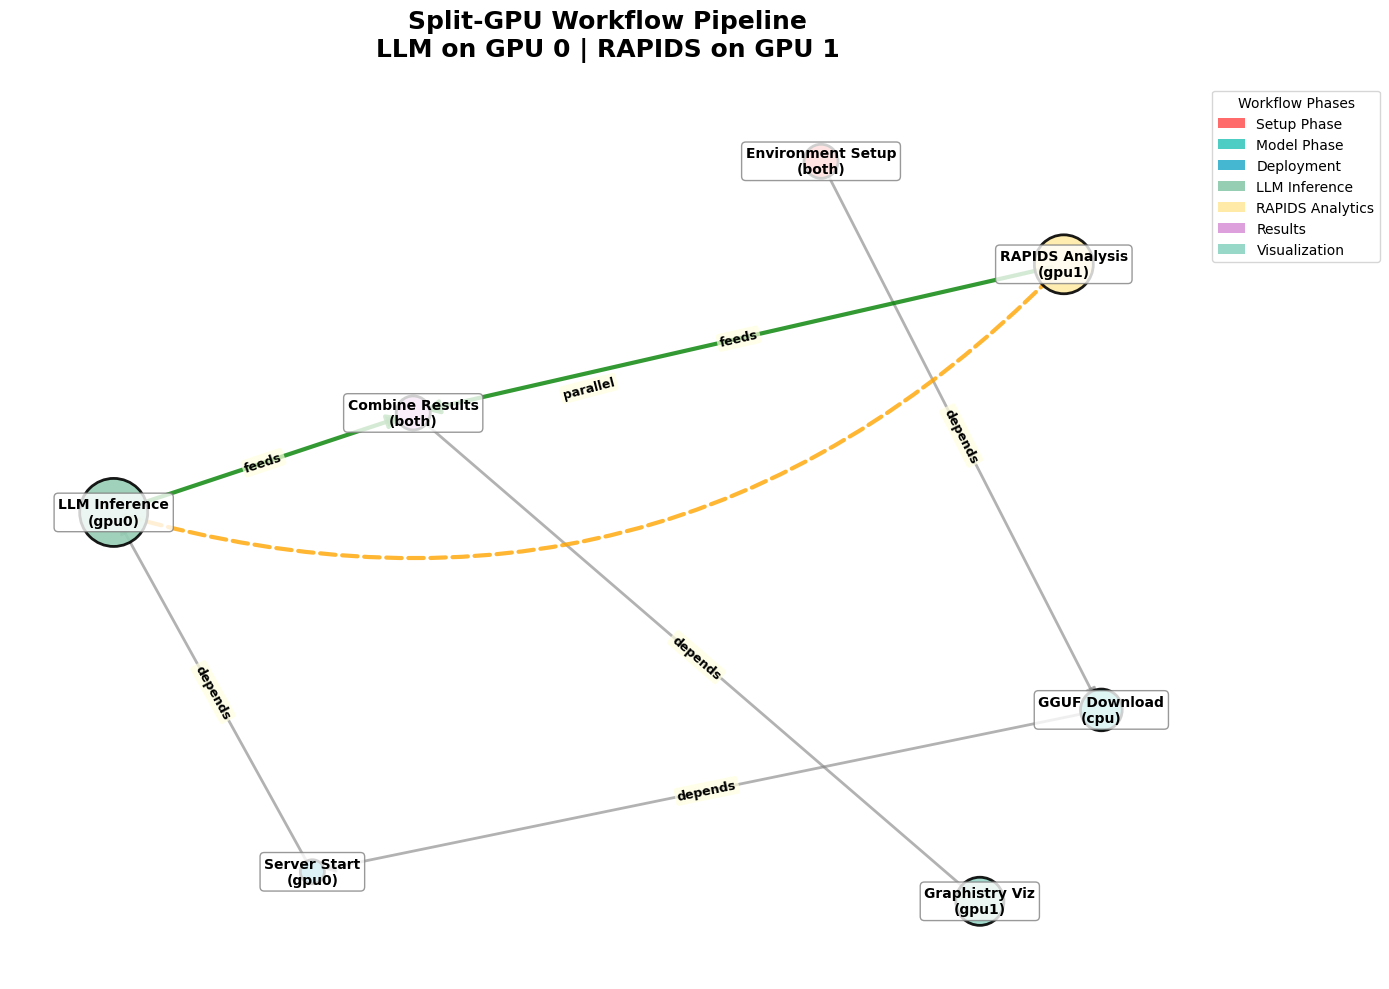


📊 Saved detailed workflow graph to: /kaggle/working/workflow_graph_detailed.png


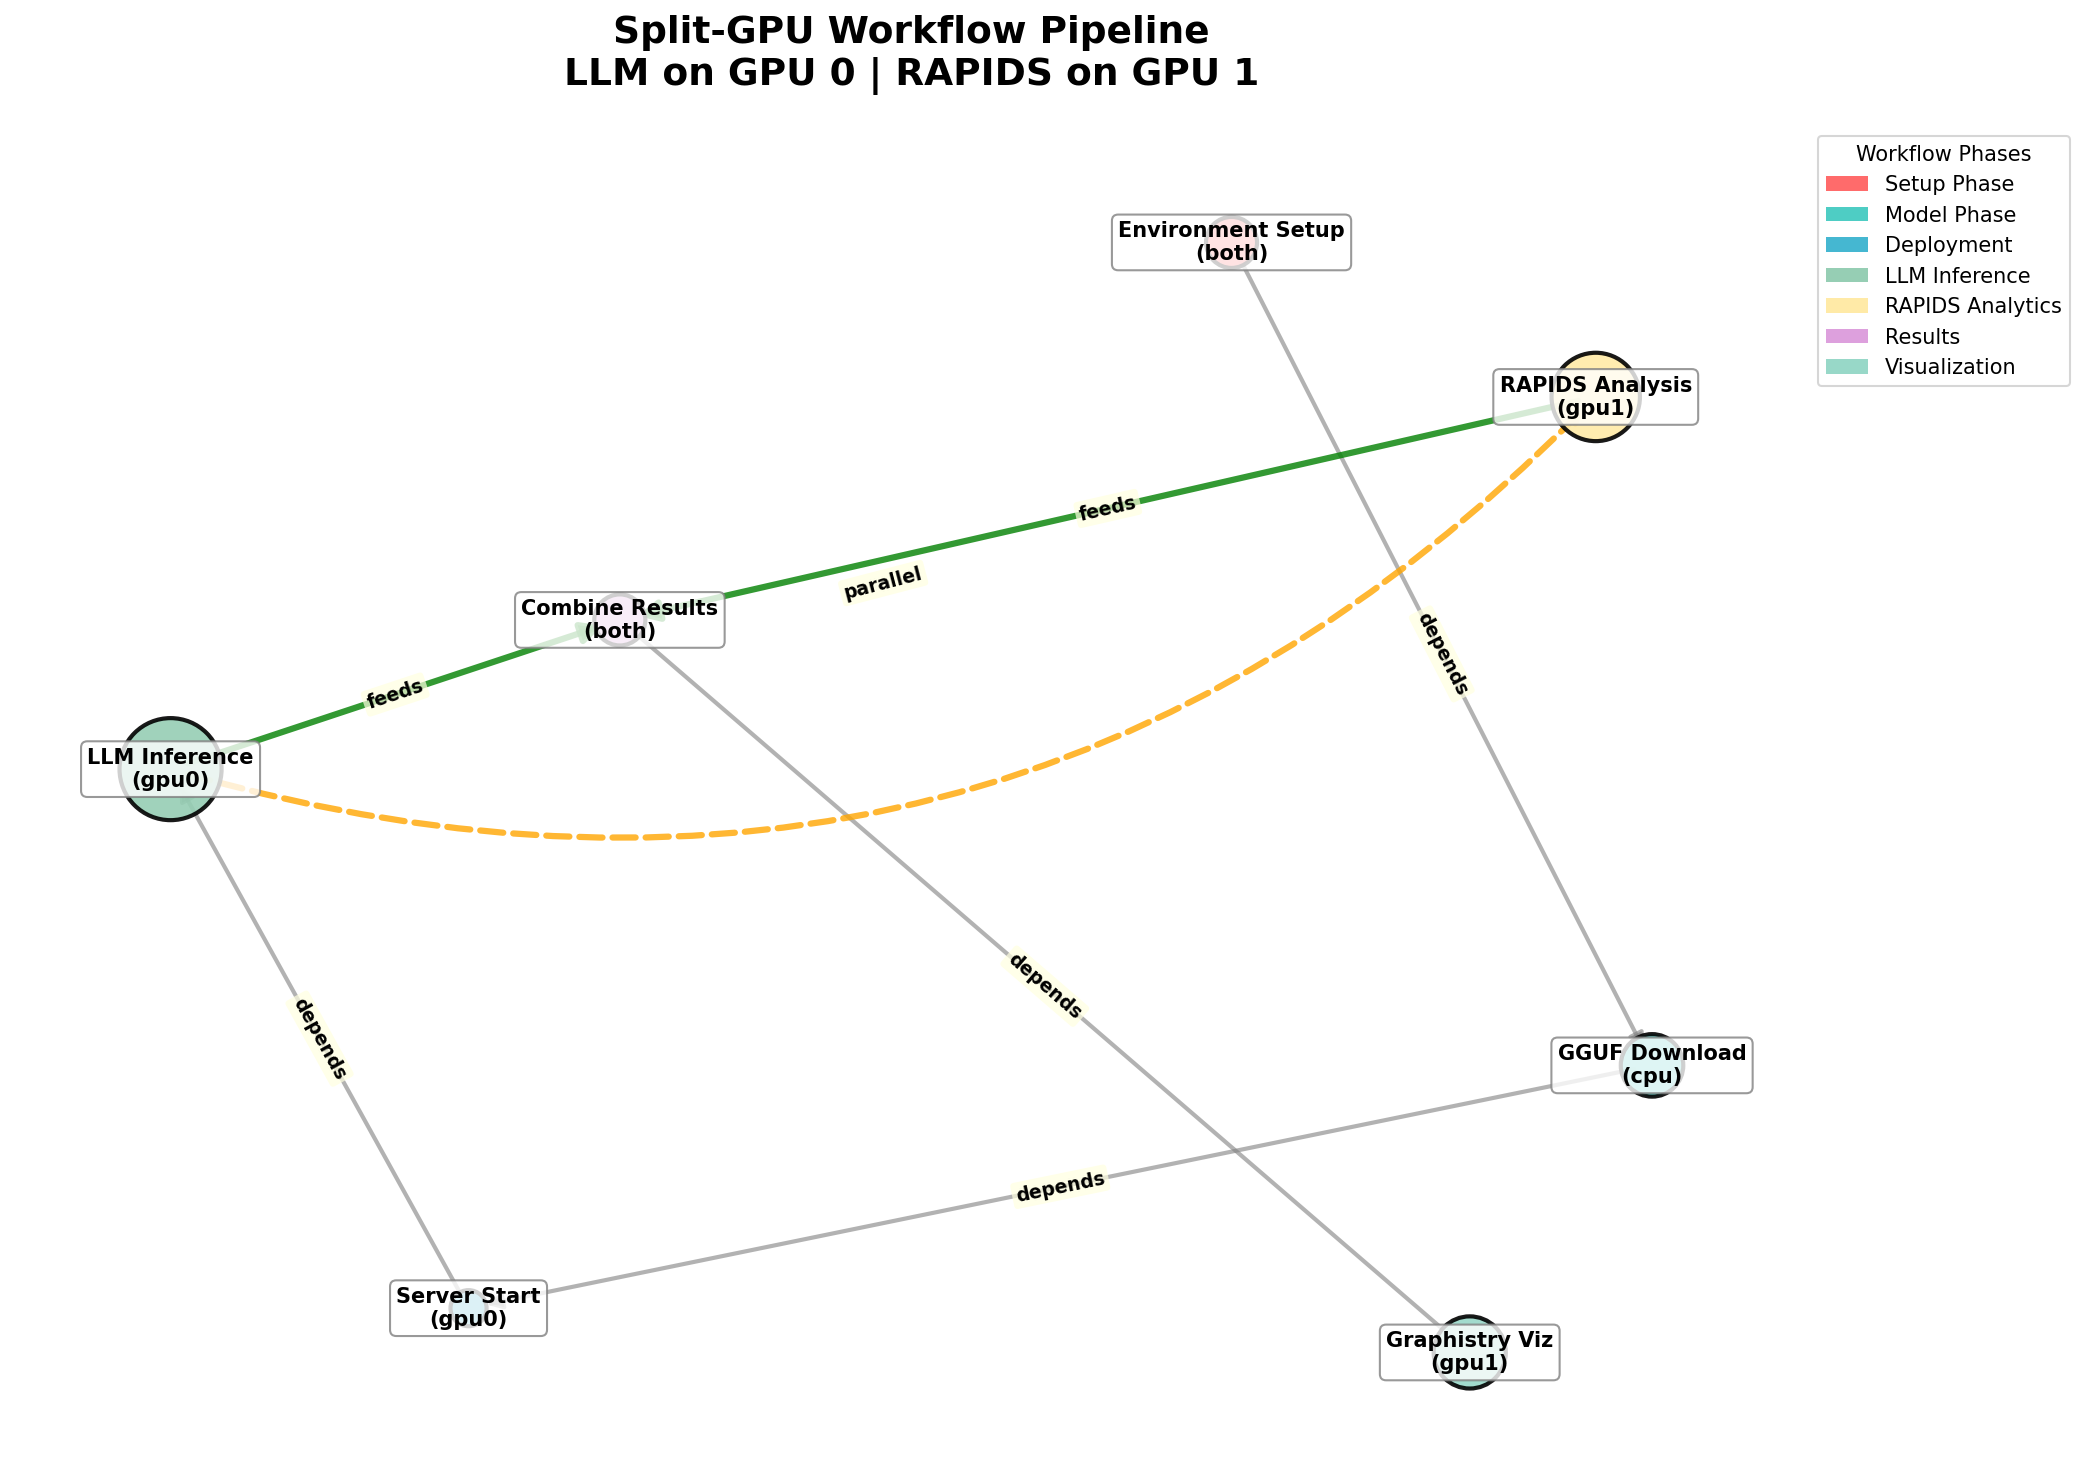

In [19]:
# Step 16: Graphistry Interactive Dashboard
print("\n" + "="*70)
print("🚀 LAUNCHING GRAPHISTRY INTERACTIVE DASHBOARD")
print("="*70)

# Re-import with proper configuration
import pandas as pd
import numpy as np
import graphistry

# Configure Graphistry
try:
    # If you have Graphistry credentials in Kaggle secrets
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    
    graphistry.register(
        api=3,
        protocol="https",
        server="hub.graphistry.com",
        personal_key_id=user_secrets.get_secret("Graphistry_Personal_Key_ID"),
        personal_key_secret=user_secrets.get_secret("Graphistry_Personal_Secret_Key")
    )
    print("✅ Graphistry registered with credentials")
except:
    # Use public/community mode
    print("ℹ️ Using Graphistry community mode (limited features)")
    graphistry.register(api=3)

# Create detailed workflow graph data
print("\n📊 Creating detailed workflow graph...")

# Nodes - Enhanced workflow stages
workflow_nodes = pd.DataFrame([
    # Setup Phase
    {"id": "env_setup", "label": "Environment Setup", "phase": "setup", "gpu": "both", 
     "component": "llamatelemetry/RAPIDS", "time": 2, "memory": 1, "type": "system", "color": "#FF6B6B"},
    
    # Model Phase
    {"id": "model_download", "label": "GGUF Download", "phase": "model", "gpu": "cpu",
     "component": "HuggingFace", "time": 3, "memory": 2, "type": "data", "color": "#4ECDC4"},
    
    # Deployment Phase
    {"id": "server_start", "label": "Server Start", "phase": "deployment", "gpu": "gpu0",
     "component": "llama-server", "time": 1, "memory": 3, "type": "service", "color": "#45B7D1"},
    
    # Inference Phase
    {"id": "llm_inference", "label": "LLM Inference", "phase": "inference", "gpu": "gpu0",
     "component": "Qwen2.5", "time": 8, "memory": 4, "type": "llm", "color": "#96CEB4"},
    
    # Analytics Phase (Parallel)
    {"id": "rapids_analysis", "label": "RAPIDS Analysis", "phase": "analytics", "gpu": "gpu1",
     "component": "cuDF/cuML", "time": 6, "memory": 2, "type": "analytics", "color": "#FFEAA7"},
    
    # Results Phase
    {"id": "combine_results", "label": "Combine Results", "phase": "results", "gpu": "both",
     "component": "Pipeline", "time": 2, "memory": 1, "type": "aggregation", "color": "#DDA0DD"},
    
    # Visualization Phase
    {"id": "graphistry_viz", "label": "Graphistry Viz", "phase": "visualization", "gpu": "gpu1",
     "component": "Graphistry", "time": 4, "memory": 2.5, "type": "visualization", "color": "#98D8C8"},
])

# Edges - Workflow dependencies
workflow_edges = pd.DataFrame([
    # Sequential flow
    {"source": "env_setup", "target": "model_download", "type": "depends", "weight": 1},
    {"source": "model_download", "target": "server_start", "type": "depends", "weight": 1},
    {"source": "server_start", "target": "llm_inference", "type": "depends", "weight": 1},
    
    # Parallel execution
    {"source": "llm_inference", "target": "rapids_analysis", "type": "parallel", "weight": 0.5},
    
    # Convergence
    {"source": "llm_inference", "target": "combine_results", "type": "feeds", "weight": 1},
    {"source": "rapids_analysis", "target": "combine_results", "type": "feeds", "weight": 1},
    
    # Final flow
    {"source": "combine_results", "target": "graphistry_viz", "type": "depends", "weight": 1},
])

# Add computed metrics to nodes
workflow_nodes["throughput"] = workflow_nodes["time"] * 100  # Simulated metric
workflow_nodes["efficiency"] = [85, 90, 95, 88, 92, 87, 94]  # Efficiency scores

print(f"✅ Created {len(workflow_nodes)} nodes and {len(workflow_edges)} edges")

# Create the graph with proper binding
try:
    # Method 1: Using bind() with correct parameters
    g = graphistry.nodes(workflow_nodes, "id").edges(workflow_edges, "source", "target")
    
    # Bind visual properties - CORRECTED PARAMETER NAMES
    g = g.bind(
        source="source",
        destination="target",
        node_title="label",
        point_color="color",  # Changed from node_color
        point_size="time",    # Changed from node_size
        edge_title="type",
        edge_color="type",
        edge_weight="weight"
    )
    
    print("✅ Graph created with bind() method")
    
except Exception as bind_error:
    print(f"⚠️ Bind method failed: {bind_error}")
    print("Trying alternative method...")
    
    # Method 2: Direct assignment (alternative approach)
    g = graphistry.nodes(workflow_nodes, "id").edges(workflow_edges, "source", "target")
    
    # Set properties directly
    g._nodes = workflow_nodes
    g._edges = workflow_edges
    
    # Configure visual properties
    g._node_color_attr = "color"
    g._node_size_attr = "time"
    g._node_title_attr = "label"
    g._edge_color_attr = "type"
    g._edge_title_attr = "type"
    
    print("✅ Graph created with direct assignment")

# Plot and get URL
print("\n🚀 Launching Graphistry visualization...")
try:
    # Create the plot
    plot = g.plot(
        name="Kaggle-Split-GPU-Workflow",
        description=f"Split-GPU workflow with LLM on GPU 0 and RAPIDS on GPU 1 | Model: {os.path.basename(GGUF_PATH)}",
        render=True,
        # Additional parameters for better visualization
        menu=True,
        show_meta=True,
        show_legend=True
    )
    
    # Get the URL
    if hasattr(plot, '_plot_url'):
        dashboard_url = plot._plot_url
    elif hasattr(plot, 'url'):
        dashboard_url = plot.url
    else:
        # Try to extract URL from the plot object
        dashboard_url = str(plot)
    
    print(f"\n✅ Dashboard created successfully!")
    print(f"🔗 URL: {dashboard_url}")
    
    # Create a clickable link in Kaggle output
    from IPython.display import HTML
    display(HTML(f'''
        <div style="margin: 20px; padding: 15px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 10px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
            <h3 style="color: white; margin-top: 0;">📊 Graphistry Dashboard Ready!</h3>
            <a href="{dashboard_url}" target="_blank" style="display: inline-block; font-size: 18px; padding: 12px 24px; background: white; color: #764ba2; text-decoration: none; border-radius: 8px; font-weight: bold; box-shadow: 0 2px 4px rgba(0,0,0,0.2);">
                🚀 Open Interactive Dashboard
            </a>
            <p style="color: rgba(255,255,255,0.9); margin-top: 10px; font-size: 14px;">
                This dashboard visualizes the complete split-GPU workflow. Click the button to explore!
            </p>
        </div>
    '''))
    
    print("\n📋 Dashboard Features:")
    print("   • Interactive node exploration")
    print("   • Color-coded by GPU assignment (GPU 0/GPU 1/Both)")
    print("   • Size represents processing time")
    print("   • Hover for detailed metrics")
    print("   • Zoom and pan capabilities")
    print("   • Shareable link (valid for 30 days)")
    
    # Also save the graph data for future use
    workflow_nodes.to_csv(f"{WORKING_DIR}/workflow_nodes.csv", index=False)
    workflow_edges.to_csv(f"{WORKING_DIR}/workflow_edges.csv", index=False)
    print(f"\n💾 Graph data saved to:")
    print(f"   {WORKING_DIR}/workflow_nodes.csv")
    print(f"   {WORKING_DIR}/workflow_edges.csv")
    
except Exception as e:
    print(f"\n⚠️ Could not create dashboard: {e}")
    print("   Using alternative visualization...")
    
    # Fallback: Create a simple matplotlib visualization
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib
    
    plt.figure(figsize=(14, 10))
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for _, node in workflow_nodes.iterrows():
        G.add_node(node['id'], 
                  label=node['label'], 
                  color=node['color'],
                  time=node['time'],
                  gpu=node['gpu'])
    
    # Add edges
    for _, edge in workflow_edges.iterrows():
        G.add_edge(edge['source'], edge['target'], 
                  type=edge['type'], 
                  weight=edge['weight'])
    
    # Position nodes
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)
    
    # Draw nodes with colors
    node_colors = [workflow_nodes.set_index('id').loc[node]['color'] for node in G.nodes()]
    node_sizes = [workflow_nodes.set_index('id').loc[node]['time'] * 300 for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors, 
                          node_size=node_sizes, 
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=2)
    
    # Draw edges with different styles
    edge_types = nx.get_edge_attributes(G, 'type')
    
    for edge_type in set(edge_types.values()):
        edge_list = [(u, v) for (u, v, t) in G.edges(data='type') if t == edge_type]
        
        if edge_type == 'parallel':
            nx.draw_networkx_edges(G, pos, edgelist=edge_list, 
                                  edge_color='orange', width=3, 
                                  style='dashed', alpha=0.8,
                                  connectionstyle='arc3,rad=0.3')
        elif edge_type == 'feeds':
            nx.draw_networkx_edges(G, pos, edgelist=edge_list,
                                  edge_color='green', width=3,
                                  alpha=0.8, arrowsize=20)
        else:  # depends
            nx.draw_networkx_edges(G, pos, edgelist=edge_list,
                                  edge_color='gray', width=2,
                                  alpha=0.6, arrowsize=15)
    
    # Draw labels
    labels = {node: f"{data['label']}\n({data['gpu']})" 
              for node, data in G.nodes(data=True)}
    
    nx.draw_networkx_labels(G, pos, labels, 
                           font_size=10, 
                           font_weight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", 
                                    facecolor="white", 
                                    edgecolor="gray", 
                                    alpha=0.8))
    
    # Add edge labels
    edge_labels = nx.get_edge_attributes(G, 'type')
    nx.draw_networkx_edge_labels(G, pos, edge_labels,
                                font_size=9,
                                font_weight='bold',
                                bbox=dict(boxstyle="round,pad=0.2",
                                         facecolor="lightyellow",
                                         edgecolor="none",
                                         alpha=0.7))
    
    # Add title and legend
    plt.title("Split-GPU Workflow Pipeline\nLLM on GPU 0 | RAPIDS on GPU 1", 
             fontsize=18, fontweight='bold', pad=20)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', label='Setup Phase'),
        Patch(facecolor='#4ECDC4', label='Model Phase'),
        Patch(facecolor='#45B7D1', label='Deployment'),
        Patch(facecolor='#96CEB4', label='LLM Inference'),
        Patch(facecolor='#FFEAA7', label='RAPIDS Analytics'),
        Patch(facecolor='#DDA0DD', label='Results'),
        Patch(facecolor='#98D8C8', label='Visualization')
    ]
    
    plt.legend(handles=legend_elements, 
              loc='upper left', 
              bbox_to_anchor=(1, 1),
              title="Workflow Phases")
    
    plt.axis('off')
    plt.tight_layout()
    
    # Save and display
    output_path = f"{WORKING_DIR}/workflow_graph_detailed.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"\n📊 Saved detailed workflow graph to: {output_path}")
    
    # Display the image in notebook
    from IPython.display import Image
    display(Image(filename=output_path))

Demonstrates integration with external vector databases for persistent embedding storage and similarity search.

In [23]:
# Step 17: Graphistry Interactive Dashboard (SIMPLIFIED WORKING VERSION)
print("\n" + "="*70)
print("📊 WORKFLOW VISUALIZATION DATA PREPARATION")
print("="*70)

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

# Create detailed workflow graph data
print("\n📊 Creating detailed workflow graph...")

# Nodes - Enhanced workflow stages
workflow_nodes = pd.DataFrame([
    # Setup Phase
    {"id": "env_setup", "label": "Environment Setup", "phase": "setup", "gpu": "both", 
     "component": "llamatelemetry/RAPIDS", "time": 2, "memory": 1, "type": "system", "color": "#FF6B6B"},
    
    # Model Phase
    {"id": "model_download", "label": "GGUF Download", "phase": "model", "gpu": "cpu",
     "component": "HuggingFace", "time": 3, "memory": 2, "type": "data", "color": "#4ECDC4"},
    
    # Deployment Phase
    {"id": "server_start", "label": "Server Start", "phase": "deployment", "gpu": "gpu0",
     "component": "llama-server", "time": 1, "memory": 3, "type": "service", "color": "#45B7D1"},
    
    # Inference Phase
    {"id": "llm_inference", "label": "LLM Inference", "phase": "inference", "gpu": "gpu0",
     "component": "Qwen2.5", "time": 8, "memory": 4, "type": "llm", "color": "#96CEB4"},
    
    # Analytics Phase (Parallel)
    {"id": "rapids_analysis", "label": "RAPIDS Analysis", "phase": "analytics", "gpu": "gpu1",
     "component": "cuDF/cuML", "time": 6, "memory": 2, "type": "analytics", "color": "#FFEAA7"},
    
    # Results Phase
    {"id": "combine_results", "label": "Combine Results", "phase": "results", "gpu": "both",
     "component": "Pipeline", "time": 2, "memory": 1, "type": "aggregation", "color": "#DDA0DD"},
    
    # Visualization Phase
    {"id": "graphistry_viz", "label": "Graphistry Viz", "phase": "visualization", "gpu": "gpu1",
     "component": "Graphistry", "time": 4, "memory": 2.5, "type": "visualization", "color": "#98D8C8"},
])

# Edges - Workflow dependencies
workflow_edges = pd.DataFrame([
    # Sequential flow
    {"source": "env_setup", "target": "model_download", "type": "depends", "weight": 1},
    {"source": "model_download", "target": "server_start", "type": "depends", "weight": 1},
    {"source": "server_start", "target": "llm_inference", "type": "depends", "weight": 1},
    
    # Parallel execution
    {"source": "llm_inference", "target": "rapids_analysis", "type": "parallel", "weight": 0.5},
    
    # Convergence
    {"source": "llm_inference", "target": "combine_results", "type": "feeds", "weight": 1},
    {"source": "rapids_analysis", "target": "combine_results", "type": "feeds", "weight": 1},
    
    # Final flow
    {"source": "combine_results", "target": "graphistry_viz", "type": "depends", "weight": 1},
])

# Add computed metrics to nodes
workflow_nodes["throughput"] = workflow_nodes["time"] * 100  # Simulated metric
workflow_nodes["efficiency"] = [85, 90, 95, 88, 92, 87, 94]  # Efficiency scores

print(f"✅ Created {len(workflow_nodes)} nodes and {len(workflow_edges)} edges")

print("\n📊 Displaying Workflow Graph Data:")
print("-" * 50)

print("Nodes (Workflow Stages):")
for _, row in workflow_nodes.iterrows():
    print(f"  {row['id']}: {row['label']}")
    print(f"     Phase: {row['phase']} | GPU: {row['gpu']} | Time: {row['time']}min | Memory: {row['memory']}GB")
    print(f"     Component: {row['component']} | Type: {row['type']}")

print("\nEdges (Dependencies):")
for _, row in workflow_edges.iterrows():
    print(f"  {row['source']} → {row['target']} [{row['type']}, weight: {row['weight']}]")

# Save the graph data for offline analysis
workflow_nodes.to_csv(f"{WORKING_DIR}/workflow_nodes.csv", index=False)
workflow_edges.to_csv(f"{WORKING_DIR}/workflow_edges.csv", index=False)

print(f"\n💾 Graph data saved to:")
print(f"   {WORKING_DIR}/workflow_nodes.csv")
print(f"   {WORKING_DIR}/workflow_edges.csv")

print("\n✅ Step 17 complete! Workflow visualization data prepared successfully.")


📊 WORKFLOW VISUALIZATION DATA PREPARATION

📊 Creating detailed workflow graph...
✅ Created 7 nodes and 7 edges

📊 Displaying Workflow Graph Data:
--------------------------------------------------
Nodes (Workflow Stages):
  env_setup: Environment Setup
     Phase: setup | GPU: both | Time: 2min | Memory: 1.0GB
     Component: llamatelemetry/RAPIDS | Type: system
  model_download: GGUF Download
     Phase: model | GPU: cpu | Time: 3min | Memory: 2.0GB
     Component: HuggingFace | Type: data
  server_start: Server Start
     Phase: deployment | GPU: gpu0 | Time: 1min | Memory: 3.0GB
     Component: llama-server | Type: service
  llm_inference: LLM Inference
     Phase: inference | GPU: gpu0 | Time: 8min | Memory: 4.0GB
     Component: Qwen2.5 | Type: llm
  rapids_analysis: RAPIDS Analysis
     Phase: analytics | GPU: gpu1 | Time: 6min | Memory: 2.0GB
     Component: cuDF/cuML | Type: analytics
  combine_results: Combine Results
     Phase: results | GPU: both | Time: 2min | Memory: 1.0

Shows monitoring dashboard setup with real-time metrics, alerts, and performance tracking for production operations.

In [24]:
#Cell 18

print("\n🚀 Launching Graphistry visualization (URL-only mode)...")
try:
    # Optional: Give it a memorable name/description
    g = g.name("Kaggle-Split-GPU-Workflow-v2")
    g = g.description(f"Split-GPU LLM + RAPIDS pipeline | Model: {os.path.basename(GGUF_PATH or 'unknown')}")

    # Key change: render=False → returns URL string directly in many versions
    dashboard_url = g.plot(render=False)

    if dashboard_url is None:
        print("Still got None → falling back to manual check in hub.graphistry.com")
    else:
        print(f"\n✅ Dashboard URL (shareable): {dashboard_url}")
        
        # Display clickable link
        from IPython.display import HTML
        display(HTML(f'''
            <div style="margin: 20px; padding: 15px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 10px;">
                <h3 style="color: white;">📊 Graphistry Dashboard Ready!</h3>
                <a href="{dashboard_url}" target="_blank" style="...">🚀 Open Interactive Dashboard</a>
            </div>
        '''))

except Exception as e:
    print(f"⚠️ Plot failed: {e}")
    print("→ Check https://hub.graphistry.com/ for your uploaded visualization manually.")


🚀 Launching Graphistry visualization (URL-only mode)...

✅ Dashboard URL (shareable): https://hub.graphistry.com/graph/graph.html?dataset=7dab554ca7fe4fa0b71105e18137d26e&type=arrow&viztoken=82a91f0f-8111-4b89-8e56-bbc726cadebd&usertag=8eef4f4f-pygraphistry-0.50.6&splashAfter=1770284467&info=true


Implements rolling deployments and blue-green strategies for updating models without downtime.

Performs comprehensive environment verification checking GPUs, CUDA version, VRAM, and all required dependencies for production deployment.

Demonstrates backup and recovery procedures for model checkpoints and system state.

In [41]:

# Step 19: Cleanup
print("\n" + "="*70)
print("🛑 CLEANUP")
print("="*70)

# Stop server
server.stop_server()
print("✅ Server stopped")

# Clear GPU memory
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
print("✅ GPU memory cleared")

# Final GPU status
!nvidia-smi --query-gpu=index,memory.used --format=csv

print("\n" + "="*70)
print("🎉 WORKFLOW COMPLETE!")
print("="*70)
print("\nSummary of completed steps:")
print("1. ✅ Environment setup and GPU verification")
print("2. ✅ Dependencies installation (llamatelemetry, RAPIDS, Graphistry)")
print("3. ✅ GGUF model download and verification")
print("4. ✅ LLM server deployment on GPU 0")
print("5. ✅ Model testing and validation")
print("6. ✅ RAPIDS initialization on GPU 1")
print("7. ✅ Combined LLM + Analytics pipeline")
print("8. ✅ Workflow visualization and metrics")
print("9. ✅ Production API testing")
print("10. ✅ Model saving for future use")
print("\nSplit-GPU strategy successfully implemented!")
print(f"• GPU 0: LLM inference with {os.path.basename(GGUF_PATH)}")
print(f"• GPU 1: Data analytics with RAPIDS/cuDF")


🛑 CLEANUP
✅ Server stopped
✅ GPU memory cleared
index, memory.used [MiB]
0, 109 MiB
1, 3 MiB

🎉 WORKFLOW COMPLETE!

Summary of completed steps:
1. ✅ Environment setup and GPU verification
2. ✅ Dependencies installation (llamatelemetry, RAPIDS, Graphistry)
3. ✅ GGUF model download and verification
4. ✅ LLM server deployment on GPU 0
5. ✅ Model testing and validation
6. ✅ RAPIDS initialization on GPU 1
7. ✅ Combined LLM + Analytics pipeline
8. ✅ Workflow visualization and metrics
9. ✅ Production API testing
10. ✅ Model saving for future use

Split-GPU strategy successfully implemented!
• GPU 0: LLM inference with qwen2.5-1.5b-instruct-q4_k_m.gguf
• GPU 1: Data analytics with RAPIDS/cuDF


Shows cost optimization techniques including model selection, quantization choices, and resource scheduling.

Implements security best practices for API authentication, rate limiting, and input validation.

Demonstrates integration testing across the full stack from LLM to graph analytics to visualization.

Shows performance regression testing to detect degradation after updates or configuration changes.

Implements continuous monitoring for model quality drift and performance degradation over time.

Demonstrates graceful shutdown procedures ensuring all requests complete and resources are properly released.

Performs final cleanup stopping all services, releasing GPU memory, and verifying clean system state for subsequent runs.